# Comparison of heatwave definitions by reference periods

Author: Hugo Carrillo

Creation: July 2024

Steps:
1. We read the cleaned data.
2. We compute the indices HWN, HWF, HWD, HWM, HWA for each year and each station, for each reference period of MeteoChile's heatwave definition.
3. We compute the correlations between the reference periods.

In [ ]:
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress specific RuntimeWarnings

In [2]:
%load_ext autoreload
%autoreload 2

# Parameters


In [23]:
CLEANED_DATA_PATH = 'data/cleaned/' 
MY_FUNCTIONS_PATH = '../functions/'
AUX_DATA_FOLDER = 'data/aux/'
PLOTS_FOLDER = 'plots/'

sns.set_theme(style="ticks")
indices = ['HWN', 'HWF', 'HWD', 'HWM', 'HWA']


In [10]:
# Add the folder to the Python path
folder_path = os.path.abspath(MY_FUNCTIONS_PATH)
sys.path.insert(0, folder_path)

from HWCompAndStats import (
    HW_indices_summary,
)

# Reading data

In [11]:
# Reading raw data of selected stations
statlist = [330007, 330020, 330030, 340031, 360011, 380013, 360019, 390006, 400009, 410005]
station_data_to_read = {}
stations_data = {}
for stat in statlist:
    stations_data[stat] = pd.read_parquet(CLEANED_DATA_PATH + f'{stat}.parquet')

stations = pd.DataFrame(index = statlist)

# Generate data for different time periods

In [12]:
HWDef = {'Tind_type': 'max_temp',
        'Tcrit_dict': {'meas': 'perc',
                        'perc': 90,
                        'adj': 'adj',
                        'set': '',
                        'Tadd': 0,
                        'hist_data_temp': 'max_temp'
                        },
        'Nd': 3}

start_year = 1971 
end_year = 2023 

ref_per_start = list(range(1970, 1995))
ref_per_end = list(range(1999, 2024))

ref_period = {}
for ii, sy in enumerate(ref_per_start):
    ref_period[sy] = [ref_per_start[ii], ref_per_end[ii]]


HWDef_dict = {}
HWDef_dict['MeteoChile'] = HWDef

HW_indices = ['HWN', 'HWF', 'HWD', 'HWM', 'HWA']

In [18]:
# OPEN OR PRODUCE DATA
filename = 'hw_Chile_summary_yws.pkl'

try:
    with open(AUX_DATA_FOLDER + filename, 'rb') as f:
        hw_Chile_summary_yws = pickle.load(f)
except Exception as e: # if the file does not exist, then we need to compute it
    print('We need to produce the necessary data. Please wait... (it takes about 2 hours)')
    hw_Chile_summary_yws = HW_indices_summary(HWDef_dict, HW_indices, ref_period, stations,
                                            start_year, end_year, stations_data = stations_data)
    # Save to pickle file
    with open(filename, 'wb') as f:
        pickle.dump(hw_Chile_summary_yws, f)

# Figure: Average over the stations

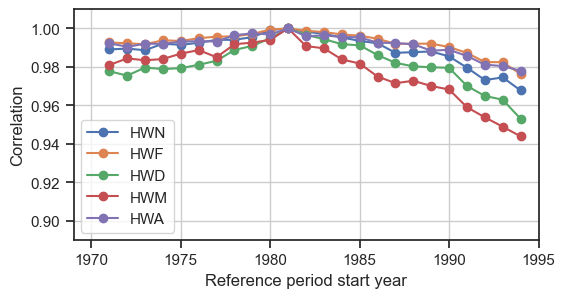

In [27]:
plt.figure(figsize = (6, 3))
corr_curves = {}
for hwi in indices:
    hw_yws = {}
    hw_yws[1981] = hw_Chile_summary_yws['MeteoChile'][1981][hwi].mean(axis=1)
    for yw in ref_per_start:
        hw_yws[yw] = hw_Chile_summary_yws['MeteoChile'][yw][hwi].mean(axis=1)
    corr_curves[hwi] = [hw_yws[1981].corr(hw_yws[yw]) for yw in ref_per_start]
    plt.plot(ref_per_start[1:], corr_curves[hwi][1:], 'o-')
plt.grid()
plt.ylim([0.89, 1.01])
plt.xlim([1969, 1995])
plt.ylabel('Correlation')
plt.xlabel('Reference period start year')
plt.legend(indices)
plt.savefig(PLOTS_FOLDER + 'Correlations_by_yw_Central_Chile.pdf', format='pdf', bbox_inches='tight')